# Plotting separate PTE terms for all simulations 

Ting-Chen Chen (ting-chen.chen@kit.edu) 

In [1]:
dt = 6
data_res  = '1x1latlon'
if   dt == 1:
     data_dt = '1hrly'
elif dt == 6:
     data_dt = '6hrly'
        
p2level = 50


In [2]:
#####################################################
# cyclone specific data
#####################################################
# channel_Xkm_0001: control simulations
# channel_Xkm_0002: +4K, qv consistent with T
# channel_Xkm_0003: +4k, qv from control
# channel_Xkm_0004: +temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0005: +tropical temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0006: +polar temperature anomaly from MPI-ESM1-2-LR far future

# Note that the  2-km experiments contain outputs every 6 hrs
# Note that the 80-km experiments contain outputs every 1 hrs


expname = {
      1: 'CTL',    
      2: 'T+4K',
      3: 'T+4K_RH-',
      4: 'T+anom',
      5: 'T+TRanom_TR',
      6: 'T+POanom'
         }

exp80 = { 
      1:'channel_80km_0001',
      2:'channel_80km_0002',
      3:'channel_80km_0003',
      4:'channel_80km_0004',
      5:'channel_80km_0005',
      6:'channel_80km_0006',
      }

exp2 = { 
      1:'channel_2km_0001',
      2:'channel_2km_0002',
      3:'channel_2km_0003',
      4:'channel_2km_0004',
      5:'channel_2km_0005',
      6:'channel_2km_0006',
      }



In [3]:
import numba
from numba import njit
import math
import psutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime  
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings
warnings.filterwarnings("ignore")
from platform import python_version

In [4]:
# Some functions: to be used for the calculations in the SPTE script

def get_es(t): 
    '''
    # t is the temperature in Kelvin
    # function that calculates the saturation vapour pressure
    '''
    es  = 6.112 * np.exp((17.67*(t-273.15))/((t-273.15)+243.5))
    return es

def get_e(t, rh):
    '''
    # rh is the relative_humidity & es is the saturation_vapour_pressure
    # function that calculates the vapour pressure
    '''
    e   = rh*get_es(t)/100
    return e

def get_shu(rh, t, p):
    '''
    # function that calculates the specific humidity
    # pressure must be given in hPa
    '''
    shu = (0.622 * get_e(t,rh))/(p-(0.378*get_e(t,rh)))
    return shu
    
def get_mix(e,p,t,rh):
    '''
    # function that calculates the mixing ratio
    # e : vapour pressure
    # p : pressure in Pa
    # t : temperature
    # rh: relative humidity
    '''
    mix = (0.622 * get_e(t,rh)) / ((p/100)-get_e(t,rh))    
    return mix
    
def get_adia_lr(t,rh,p):
    '''
    # function that calculates the dry/moist adiabatic lapse rate
    # t : temperature
    # rh: relative humidity
    '''
    if rh < 95.:
        adia = g/C_p
    else:
        e_h   = get_e(t,rh)
        mix_h = get_mix(e_h, p, t, rh)
        adia  = g * ((1 + ((LV * mix_h) / (R * t))) / (C_p + ((LV**2 * mix_h * 0.622) / (R * t**2))))
    return adia

def get_rhm_sfc(t2m ,td2m):
    '''
    # function that calculates the relative humidity in the sfc
    '''
    rhm_sfc = 100 * (get_es(td2m)/get_es(t2m))
    return rhm_sfc

def get_theta(t, p):
    '''
    # function that calculates the potential temperature for given Temperature(t in Kelvin) and pressure,
    '''
    theta = t * ( 1.e5 / p) ** 0.286
    return theta

def get_T_v(t, shu):
    '''
    # function that calculates the virtual temperature for given Temperature(t in Kelvin),
    # Relative Humidity(rh [0-100]) & Pressure(p in hPa)
    # we calculate the specific humidity
    '''
    T_v = t * (1 + 0.608 * shu)
    return T_v

@njit
def get_T_adv(T, u, v, lat, lon, ntimes, nlevs, nlats, nlons):
    '''
    # function that calculates the Horizontal Temperature Advection (T_adv)
    # we use as imput the u and v wind components with shape (ntimes, nlevs, nlats, nlons)
    # and the temperature gradient components with shape (ntimes, nlevs, nlats, nlons)
    '''
    deg2rad = np.pi/180.0
    
    T_adv = np.full((ntimes,nlevs,nlats,nlons),np.nan,dtype=np.float64)
    
    for lati in range(nlats):
        for loni in range(nlons):
            
            latiU = min (lati+1, nlats-1)
            latiL = max (lati-1, 0)
            #loniU = min (loni+1, nlons-1)
            #loniL = max (loni-1, 0)
            loniU = loni+1
            loniL = loni-1
            londis = lon[loniU]-lon[loniL]
            if loni == nlons-1:
                loniU = 0
                londis = 2.
            if loni == 0:    
                londis = 2.
                
            # Zonal distance between two points at the same latitude 
            #------------------------------------------------------------------------------------------------------------------------------
            # Based on an ellipsoid (e.g. WGS84):
            # ps., more realistic for the Earth but not necessary the assumption used in the numerical NWP/climate models!
            #
            # zon = u[:,:,lati,loni]/(rearth*np.cos(lat[lati]*deg2rad)) * (T[:,:,lati,loniU]-T[:,:,lati,loniL])/(deg2rad*(lon[loniU]-lon[loniL]))
            #------------------------------------------------------------------------------------------------------------------------------
            #------------------------------------------------------------------------------------------------------------------------------
            # Based on a sphere with a constant radius:
            # ps., likely used in ICON-NWP models!
            # 
            zon = u[:,:,lati,loni]/rearth * (T[:,:,lati,loniU]-T[:,:,lati,loniL])/(deg2rad*(londis))
            mer = v[:,:,lati,loni]/rearth * (T[:,:,latiU,loni]-T[:,:,latiL,loni])/(deg2rad*(lat[latiU]-lat[latiL]))   
            T_adv[:,:,lati,loni] = -1* (zon + mer)
            
    return T_adv
       
def get_ro_sfc(t_sfc, p_sfc):
    '''
    # function that calculates the density in the surface for given surface pressure
    # and temperature (conventionally we can use temprature at 2 m)
    # Pressure    in Pa
    # Temperature in K
    '''
    ro   = np.full((ntimes,nlats,nlons),np.nan,dtype=float)
    ro   = p_sfc / (t_sfc * R)    
    return ro  


def get_ro_lpl(tv, p, ntimes, nlats, nlons, nlevs):
    '''
    # function that calculates the 4D density 
    '''
    
    ro_lpl = np.full(tv.shape,np.nan,dtype=np.float64) 
    for ti in range(ntimes):
        for la in range(nlats):
            for lo in range(nlons):
                for il in range (nlevs):
                    ro_lpl[ti,la,lo]   = p[ti,il,la,lo] / (tv[ti,il,la,lo] * R)
    return ro_lpl

@njit
def get_dT_dp(t, p, ntimes, nlevs, nlats, nlons):
    '''
    # function that calculates the vertical temperature gradient
    '''
    dT_dp = np.full((ntimes,nlevs,nlats,nlons),np.nan,dtype=np.float64)
    #dT_dp = np.full((ntimes,nlevs+1,nlats,nlons), np.nan,dtype=float)
    for ti in range(ntimes):
        for le in range(nlevs):
            leU = min (le+1, nlevs-1)
            leL = max (le-1, 0)
            dT_dp[ti,le,:,:] = (t[ti,leU,:,:]-t[ti,leL,:,:]) / (p[ti,leU,:,:]-p[ti,leL,:,:]) 
     
    return dT_dp

def get_dT_dz(dT_dp, ro):
    '''
    # function that calculates the tempertature advetion due to vertical motions
    '''
    dT_dz = dT_dp * ( -ro ) * g 
    
    return dT_dz
           
def get_T_vmt_dry(T_v, dTv_dp, omega, level):
    '''
    # function that calculates the tempertature advetion due to vertical motions
    '''
    T_vmt = omega * ( (R * T_v ) / ( C_p * level) - dTv_dp) 
    
    return T_vmt  

@njit
def get_p_levs(level,ntimes,nlevs,nlats,nlons):
    
    p_levs = np.full((ntimes,nlevs,nlats,nlons), np.nan , dtype=np.float64)
    for ti in range(ntimes):
        for la in range(nlats):
            for lo in range(nlons):
                p_levs[ti,:,la,lo] = level

    return p_levs

@njit
def logp_integral(var_datanan0,logp1D,ro,ntimes,nlats,nlons):
    
    I_var  = np.full((ntimes,nlats,nlons), np.nan, dtype=np.float64)
    for ti in range(ntimes):
        for la in range(nlats):
            for lo in range(nlons):
                I_var[ti,la,lo] = np.trapz(var_datanan0[ti,:,la,lo],x=logp1D)*-1 *dt * h_in_sec * ro[ti,la,lo] * R
    return I_var

@njit
def logp_integral_simple(var_datanan0,logp1D,ro,ntimes,nlats,nlons):
    
    I_var  = np.full((ntimes,nlats,nlons), np.nan, dtype=np.float64)
    for ti in range(ntimes):
        for la in range(nlats):
            for lo in range(nlons):
                I_var[ti,la,lo] = np.trapz(var_datanan0[ti,:,la,lo],x=logp1D)
    return I_var


def get_pv(vor,dT_dp):

    PV = (vor+f) * dT_dp * -g
                
    return PV


In [5]:
experiments  = [exp80[1],exp80[2],exp80[3],exp80[4],exp80[5],exp80[6],exp2[1],exp2[2],exp2[3],exp2[4],exp2[5],exp2[6],]

In [6]:
def createList(r1, r2, r3):
    return list(range(r1, r2+1, r3))

def load_iconsimulation(expid):

    datapath='/work/bb1152/Module_A/A6_CyclEx/sim_data/production/'

#----2D atmospheric variables----
    ipath2d   = datapath+expid+"/remapped_atm2d_latlon/"
    ifile2d   = "icon-atm2d_ML_reg_con_202101*.nc"

    print(ipath2d+ifile2d)

#----3D atmospheric variables----
    ipath3d   = datapath+expid+"/remapped_atm3d_latlon/"
    ifile3d   = "icon-atm3d_PL_reg_con_202101*.nc"

    print(ipath3d+ifile3d)
    
    ds2d     = xr.open_mfdataset(ipath2d+ifile2d)
    ds3d     = xr.open_mfdataset(ipath3d+ifile3d)
    # select required variables

    ds3d = ds3d[['temp',
            'qv',
            'vor']]
# pres_sfc: surface pressure [Pa]
# pres_msl: mea-sea-level pressure [Pa]
# tot_prec: total precipitation [kg m-2]
# qhfl_s: surface moisture flux [Kg m-2 s-1]
# t_2m: temperature in 2m [K]
# qv_2m: specific water vapor content in 2m 
    ds2d = ds2d[['pres_sfc',
             'pres_msl',
             ]]   

    ds = xr.merge([ds2d,ds3d])
    if (expid in list(exp80.values())):
    
        if data_dt =='6hrly':
    
            ds = ds.isel(time=createList(36,216+1,6))  # day 2.5- 9, every 6 hr (starting from t=0)
        
        elif data_dt =='1hrly':
    
            ds = ds.isel(time=slice(36,216+1))        # day 2.5- 9, every 1 hr

    else :  #2-km experiments
    
        ds = ds.isel(time=slice(6,36+1))
    
    ds["time"] = ds.time - 20210101
    # Select subdomain without meridional boundaries

    latmin = 15 # idea: could use the minimum domain required in terms of lat here
    latmax = 80

# Do not cut the west-east sides of the domains as the cyclone
# moves periodically in the zonal direction! 
    ds = ds.sel(lat=slice(latmin,latmax))
    return ds

In [7]:
ds = {}

for exp in experiments:
    ds[exp] = load_iconsimulation(exp)

/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_80km_0001/remapped_atm2d_latlon/icon-atm2d_ML_reg_con_202101*.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_80km_0001/remapped_atm3d_latlon/icon-atm3d_PL_reg_con_202101*.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_80km_0002/remapped_atm2d_latlon/icon-atm2d_ML_reg_con_202101*.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_80km_0002/remapped_atm3d_latlon/icon-atm3d_PL_reg_con_202101*.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_80km_0003/remapped_atm2d_latlon/icon-atm2d_ML_reg_con_202101*.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_80km_0003/remapped_atm3d_latlon/icon-atm3d_PL_reg_con_202101*.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_80km_0004/remapped_atm2d_latlon/icon-atm2d_ML_reg_con_202101*.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_80km_0004/remapped_atm3d_latlon/icon-atm3d_PL_reg_con_202101*.nc


In [8]:
# Some constant values
rearth   = 6.356766E+06       # earth's radius
R        = 287.04             # gas constant
C_p      = 1005.7             # specific heat capacity
g        = 9.81               # gravitational acceleration
LV       = 2.501E+06          # latent heat of vaporization at 0C
f        = 1.0E-04            # Coriolis parameter

In [9]:
# Read the data from model outputs
for exp in experiments:
    
    # Select required variables
    ds[exp] = ds[exp][['lon',
                       'lat',
                       'time',
                       'temp',
                       'plev_3',
                       'qv',
                       'vor',
                       #'u', # at 850 hPa
                       #'v', # at 850 hPa
                       'pres_msl']]
    
    lons         = ds[exp].variables['lon'][:].to_numpy()
    lats         = ds[exp].variables['lat'][:].to_numpy()
    time         = ds[exp].variables['time'][:].to_numpy()
    level        = ds[exp].variables['plev_3'][:].to_numpy() 
    ntimes    = len(time)
    nlevs     = len(level)
    nlons     = len(lons)
    nlats     = len(lats)
    level        = ds[exp].variables['plev_3'][:].to_numpy()              # pressure [Pa]
    t            = ds[exp].variables['temp'][:].to_numpy()                # temperature [K]
    shu          = ds[exp].variables['qv'][:].to_numpy()                  # specific humidity [kg/kg]
    vor          = ds[exp].variables['vor'][:].to_numpy()                 # relative vorticity
    mslp         = ds[exp].variables['pres_msl'][:].to_numpy()
      
    p_levs = get_p_levs(level,ntimes,nlevs,nlats,nlons)
    theta  = get_theta(t,p_levs)
    dthetadp = get_dT_dp(theta, p_levs, ntimes, nlevs, nlats, nlons)
    pv       = get_pv(vor,dthetadp)
    T_v      = get_T_v(t,shu)
    pv_upper =pv[:,19:40,:,:]
    pv_lower =pv[:,69:90,:,:]
    pvuppavg = np.mean(pv_upper, axis=1)
    pvlowavg = np.mean(pv_lower, axis=1)
    ds[exp]['T_v']   = (("time", "plev_3", "lat", "lon"), T_v)
    ds[exp]['lowpv'] = (("time", "lat", "lon"), pvlowavg)
    ds[exp]['upppv'] = (("time", "lat", "lon"), pvuppavg)


In [10]:
def read_track_data(exp,track_dur,track_lon,track_lat,track_pmin):

    # path
    path_track = '/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_tracks/'

    df_track = pd.read_csv(path_track+'Track_for_'+exp+'_6hrly_1x1latlon.csv')
    
    # extract vars of interest
    track_dur[exp]  = df_track['time']
    track_lon[exp]  = df_track['lon']
    track_lat[exp]  = df_track['lat']
    track_pmin[exp] = df_track['pmin']
    
    return track_dur,track_lon,track_lat,track_pmin

In [11]:
track_dur  = {}
track_lon  = {}
track_lat  = {}
track_pmin = {}

for exp in experiments:
    track_dur,track_lon,track_lat,track_pmin = read_track_data(exp,
                                                               track_dur,
                                                               track_lon,
                                                               track_lat,
                                                               track_pmin)

Simulation on day  6.5


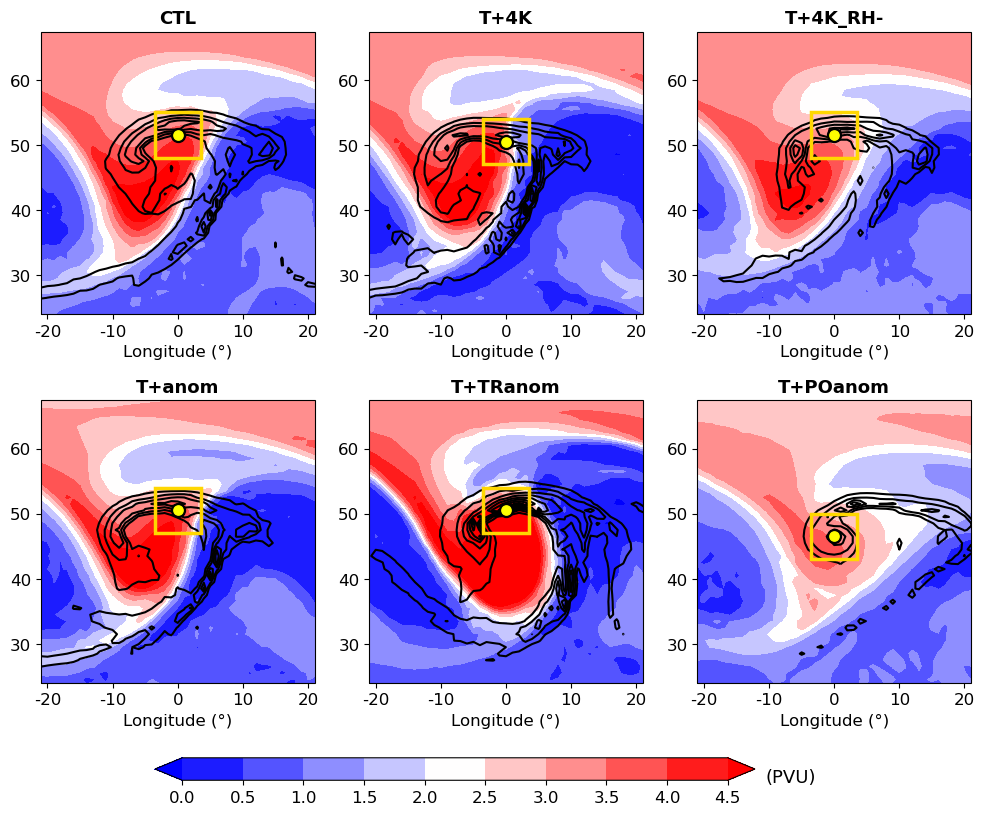

In [16]:
# Check the PTE results!

plt.rcParams['savefig.facecolor']='white'

lonmin=lons.min()+5
lonmax=lons.max()-4

latmin0=24
latmax0=66
latmin2=34
latmax2=63
latmin3=34
latmax3=63
# Showing Dp/dt term at a given time step
stp2 = 16 #5.25 day

print('Simulation on day ',time[stp2]+1)


lev1 = 9+10+5  #250 hPa
lev2 = 9+10+10+10+10 #500hPa
lev3 = 9+10+10+10+10+10+10+15 # 850 hPa
#lev = 9: 100hPa in our intepolated input data
ctv = 'k'
cmap = 'bwr'
clevsomg=np.arange(-150,210,30)
# --------------------------------------------

tfact = (6/dt) # This is for an easier comparison between the 6-h vs 1-h results (converting to the same unit)
clevs_mslp=np.arange(906,1060,6)
clevs=np.arange(-6e-4,7e-4,1e-4)
clevs_Tv=np.arange(170,380,5)
#clevs_geop=np.arange(820,10720,80)
#clevs_geop=np.arange(820,10720,100)
clevs_geop=np.arange(930,10720,100)
clevs_pv = np.arange(0,5,0.5)
clevs_pv2= np.arange(1,5,0.5)

def load_plot(ax1,exp,shift_lon2,stp2,text,clab=False):
    upv_avg_roll2=np.roll(ds[exp]['upppv'],shift_lon2,axis=2)
    lpv_avg_roll2=np.roll(ds[exp]['lowpv'],shift_lon2,axis=2)
    mslp_roll2=np.roll(ds[exp]['pres_msl'],shift_lon2,axis=2)
    Tv_roll2=np.roll(ds[exp]['T_v'],shift_lon2,axis=3)
    
    ntrack = len(track_dur[exp])
    for i in range(ntrack):
    #find timestep corresponding to track and data
        if track_dur[exp][i] == ds[exp]['time'][stp2]:
            cen_lon2=track_lon[exp][i]+shift_lon2
            cen_lat2=track_lat[exp][i]
           
    ax1.set_extent([cen_lon2-21, cen_lon2+21, latmin0, latmax0])    
    cd = plt.contourf(ds[exp]['lon'],ds[exp]['lat'],upv_avg_roll2[stp2,:,:]*1.e6,clevs_pv, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
    cd2= plt.contour(ds[exp]['lon'],ds[exp]['lat'],lpv_avg_roll2[stp2,:,:]*1.e6,clevs_pv2,colors='k',linewidths=1.5,
                     extend='both',transform=ccrs.PlateCarree())
  # clabels = plt.clabel(cd2,inline=True,fmt='%1.f', fontsize=10) 
  # [txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5)) for txt in clabels]
   #cdc = plt.contour(ds[exp]['lon'],ds[exp]['lat'],Tv_roll2[stp2,lev3,:,:],clevs_Tv,colors='gray',linewidths=1,transform=ccrs.PlateCarree())


    ax1.set_yticks([30,40,50,60])
    #ax1.set_ylabel('Latitude (°)',fontsize=12)
    ax1.set_yticklabels(['30','40','50','60'])

    
    ax1.set_xticks([cen_lon2-20, cen_lon2-10,cen_lon2,cen_lon2+10,cen_lon2+20])
    ax1.set_xlabel('Longitude (°)',fontsize=12)
    ax1.set_xticklabels([-20,-10,0,10,20])
    ax1.tick_params(axis='both', labelsize=12)
        #plt.scatter(cen_lon, cen_lat, c='k', s=80, zorder=25,transform=ccrs.PlateCarree())
    plt.scatter(cen_lon2, cen_lat2, c='k', s=100,zorder=20)
    plt.scatter(cen_lon2, cen_lat2, c='yellow', s=45, zorder=20)
    plt.title(text,fontsize=13,weight='bold')
    boxsize = 7 # horizontal size of column in deg used for PTE analysis

    ax1.add_patch(plt.Rectangle((cen_lon2-boxsize/2,
                                 cen_lat2-boxsize/2),
                                 boxsize,
                                 boxsize,
                                 fc='none',
                                 #ec='#1E62DE',
                                 ec='gold',
                                 ls='solid',
                                 linewidth=2.5,
                                 zorder=20,
                                 alpha=1))
    if clab: 
        cbar_ax = fig.add_axes([0.22, 0.01, 0.5, 0.025]) # left,bottom,width,height
        clb = plt.colorbar(cd,
                cax=cbar_ax,
                shrink=0.8,
                orientation='horizontal',
                extend='max')
        tick_font_size = 12
        clb.ax.tick_params(labelsize=tick_font_size)
        clb.ax.set_title('(PVU)', fontsize=13, x=1.07, y=-0.1, ha='left',
                 transform=clb.ax.transAxes)
        
  


fig = plt.figure(figsize=(12,9))
# CTL 
ax1 = plt.subplot(2,3,1,projection=ccrs.PlateCarree()) 
exp=exp2[1]
shift_lon2=-10 
load_plot(ax1,exp,shift_lon2,stp2,'CTL')

# T+4K 
ax2 = plt.subplot(2,3,2,projection=ccrs.PlateCarree()) 
exp=exp2[2]
shift_lon2=-13
load_plot(ax2,exp,shift_lon2,stp2,'T+4K')

# T+4K_RH-
ax3 = plt.subplot(2,3,3,projection=ccrs.PlateCarree()) 
exp=exp2[3]
shift_lon2=-13
load_plot(ax3,exp,shift_lon2,stp2,'T+4K_RH-')

 # T+anom
ax4 = plt.subplot(2,3,4,projection=ccrs.PlateCarree()) 
exp=exp2[4]
shift_lon2=-20
load_plot(ax4,exp,shift_lon2,stp2,'T+anom')

# T+TRanom
ax5 = plt.subplot(2,3,5,projection=ccrs.PlateCarree()) 
exp=exp2[5]
if (exp in list(exp2.values())):
    shift_lon2=20
else:
    shift_lon2=-20
load_plot(ax5,exp, shift_lon2,stp2,'T+TRanom')

# T+POanom
ax6 = plt.subplot(2,3,6,projection=ccrs.PlateCarree()) 
exp=exp2[6]
if (exp in list(exp2.values())):
    shift_lon2=5
else:
    shift_lon2=-0
load_plot(ax6,exp,shift_lon2,stp2,'T+POanom',clab=True)
  
     
#===============================================

fig.subplots_adjust(wspace = 0.2, hspace = 0.05)
fig.subplots_adjust(bottom=0.08)

#fig1.suptitle('Tadv (shaded) & mslp (contours) on Day '+str(time[stp])+'\n'+exp+'',fontsize=14, weight='bold')
#plt.title('Day 6.5')
#if exp == 'channel_80km_0001':
#    plt.savefig('FigR7_Tadv_diab_'+exp+'_Day4p5&6p5.png', bbox_inches='tight',dpi=100)
#else: 
plt.savefig('Upper&lowerPV_allexp2p5km_Day6p5.png', bbox_inches='tight',dpi=150)
plt.show()

In [ ]:
# Check the PTE results!

plt.rcParams['savefig.facecolor']='white'

lonmin=lons.min()+5
lonmax=lons.max()-4

latmin0=24
latmax0=66
latmin2=34
latmax2=63
latmin3=34
latmax3=63
# Showing Dp/dt term at a given time step
stp2 = 13 #5.25 day

print('Simulation on day ',time[stp2]+1)


lev1 = 9+10+5  #250 hPa
lev2 = 9+10+10+10+10 #500hPa
lev3 = 9+10+10+10+10+10+10+15 # 850 hPa
#lev = 9: 100hPa in our intepolated input data
ctv = 'k'
cmap = 'bwr'
clevsomg=np.arange(-150,210,30)
# --------------------------------------------

tfact = (6/dt) # This is for an easier comparison between the 6-h vs 1-h results (converting to the same unit)
clevs_mslp=np.arange(906,1060,6)
clevs=np.arange(-6e-4,7e-4,1e-4)
clevs_Tv=np.arange(170,380,5)
#clevs_geop=np.arange(820,10720,80)
#clevs_geop=np.arange(820,10720,100)
clevs_geop=np.arange(930,10720,100)
clevs_pv = np.arange(0,5.5,0.5)
clevs_pv2= np.arange(1,4.5,0.5)

def load_plot(ax1,exp,shift_lon2,stp2,text):
    upv_avg_roll2=np.roll(ds[exp]['upppv'],shift_lon2,axis=2)
    lpv_avg_roll2=np.roll(ds[exp]['lowpv'],shift_lon2,axis=2)
    mslp_roll2=np.roll(ds[exp]['pres_msl'],shift_lon2,axis=2)
    Tv_roll2=np.roll(ds[exp]['T_v'],shift_lon2,axis=3)
    
    ntrack = len(track_dur[exp])
    for i in range(ntrack):
    #find timestep corresponding to track and data
        if track_dur[exp][i] == ds[exp]['time'][stp2]:
            cen_lon2=track_lon[exp][i]+shift_lon2
            cen_lat2=track_lat[exp][i]
           
    ax1.set_extent([cen_lon2-21, cen_lon2+21, latmin0, latmax0])    
    cd = plt.contourf(ds[exp]['lon'],ds[exp]['lat'],upv_avg_roll2[stp2,:,:]*1.e6,clevs_pv, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
    cd2= plt.contour(ds[exp]['lon'],ds[exp]['lat'],lpv_avg_roll2[stp2,:,:]*1.e6,clevs_pv2,colors='k',linewidths=1.2,
                     extend='both',transform=ccrs.PlateCarree())
  # clabels = plt.clabel(cd2,inline=True,fmt='%1.f', fontsize=10) 
  # [txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5)) for txt in clabels]
   #cdc = plt.contour(ds[exp]['lon'],ds[exp]['lat'],Tv_roll2[stp2,lev3,:,:],clevs_Tv,colors='gray',linewidths=1,transform=ccrs.PlateCarree())


    ax1.set_yticks([30,40,50,60])
    #ax1.set_ylabel('Latitude (°)',fontsize=12)
    ax1.set_yticklabels(['30','40','50','60'])

    
    ax1.set_xticks([cen_lon2-20, cen_lon2-10,cen_lon2,cen_lon2+10,cen_lon2+20])
    ax1.set_xlabel('Longitude (°)',fontsize=12)
    ax1.set_xticklabels([-20,-10,0,10,20])
    ax1.tick_params(axis='both', labelsize=12)
        #plt.scatter(cen_lon, cen_lat, c='k', s=80, zorder=25,transform=ccrs.PlateCarree())
    plt.scatter(cen_lon2, cen_lat2, c='k', s=100,zorder=20)
    plt.scatter(cen_lon2, cen_lat2, c='yellow', s=45, zorder=20)
    plt.title(text,fontsize=13,weight='bold')
    boxsize = 7 # horizontal size of column in deg used for PTE analysis

    ax1.add_patch(plt.Rectangle((cen_lon2-boxsize/2,
                                 cen_lat2-boxsize/2),
                                 boxsize,
                                 boxsize,
                                 fc='none',
                                 #ec='#1E62DE',
                                 ec='gold',
                                 ls='solid',
                                 linewidth=2.5,
                                 zorder=20,
                                 alpha=1))


fig = plt.figure(figsize=(12,9))
# CTL 
ax1 = plt.subplot(2,3,1,projection=ccrs.PlateCarree()) 
exp=exp80[1]
shift_lon2=-7
load_plot(ax1,exp,shift_lon2,stp2,'CTL')

# T+4K 
ax2 = plt.subplot(2,3,2,projection=ccrs.PlateCarree()) 
exp=exp80[2]
shift_lon2=-7
load_plot(ax2,exp,shift_lon2,stp2,'T+4K')

# T+4K_RH-
ax3 = plt.subplot(2,3,3,projection=ccrs.PlateCarree()) 
exp=exp80[3]
shift_lon2=3
load_plot(ax3,exp,shift_lon2,stp2,'T+4K_RH-')

 # T+anom
ax4 = plt.subplot(2,3,4,projection=ccrs.PlateCarree()) 
exp=exp80[4]
shift_lon2=-8
load_plot(ax4,exp,shift_lon2,stp2,'T+anom')

# T+TRanom
ax5 = plt.subplot(2,3,5,projection=ccrs.PlateCarree()) 
exp=exp80[5]
if res=='2km':
    shift_lon2=20
else:
    shift_lon2=-20
load_plot(ax5,exp,-20,stp2,'T+TRanom')

# T+POanom
ax6 = plt.subplot(2,3,6,projection=ccrs.PlateCarree()) 
exp=exp80[6]
if res=='2km':
    shift_lon2=5
else:
    shift_lon2=+5
load_plot(ax6,exp,+8,stp2,'T+POanom')
  
     
#===============================================

fig.subplots_adjust(wspace = 0.2, hspace = 0.05)
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.22, 0.01, 0.5, 0.025]) # left,bottom,width,height
clb = plt.colorbar(cd,
                cax=cbar_ax,
                shrink=0.8,
                orientation='horizontal',
                extend='max')
        
        
#cb = fig.colorbar(cd, cax=cbar_ax, orientation='horizontal', extend='max')
tick_font_size = 12
clb.ax.tick_params(labelsize=tick_font_size)
clb.ax.set_title('(PVU)', fontsize=13, x=1.07, y=-0.1, ha='left',
             transform=clb.ax.transAxes)
#fig1.suptitle('Tadv (shaded) & mslp (contours) on Day '+str(time[stp])+'\n'+exp+'',fontsize=14, weight='bold')
#plt.title('Day 6.5')
#if exp == 'channel_80km_0001':
#    plt.savefig('FigR7_Tadv_diab_'+exp+'_Day4p5&6p5.png', bbox_inches='tight',dpi=100)
#else: 
plt.savefig('Upper&lowerPV_allexp_Day5p75.png', bbox_inches='tight',dpi=150)
plt.show()